In [1]:
import numpy as np
from chmm_actions import CHMM, forwardE, datagen_structured_obs_room
import matplotlib.pyplot as plt
import igraph
from matplotlib import cm, colors
import sys, os, pickle

retrain_models = False

custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
        ]
    )
    / 256
)

if not os.path.exists("figures"):
    os.makedirs("figures")

In [2]:
def plot_graph(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out

In [3]:
def datagen_structured_obs_linear_track(
    linear_track,
    start_r=None,
    length=10000,
    seed=42,
):
    """linear_track is a 2d numpy array. Each row represents one possible
    variation of the track. The rat can only perform one action (right) to move
    forward along the track. After reaching the end of the track, the right
    action takes the rat to the start of a random (uniformly selected) track.

    Returns:
      a: a list of action states, every element will be 1, the action corresponding to right
      x: list of observations
      rc: the row, col that the rat is at during the observation

    """
    np.random.seed(seed)
    n_r, n_c = linear_track.shape
    if start_r is None:
        start_r = np.random.randint(n_r)
    start_c = 0

    actions = np.ones(length, int) * 1 #1 is right
    x = np.zeros(length, int)  # observations
    rc = np.zeros((length, 2), int)  # actual r&c

    r, c = start_r, start_c
    x[0] = linear_track[r, c]
    rc[0] = r, c

    count = 0
    while count < length - 1:

        if c < n_c - 1:
            c += 1
        else:
          c = 0
          r = np.random.randint(n_r)


        x[count + 1] = linear_track[r, c]
        rc[count + 1] = r, c
        count += 1

    return actions, x, rc

n_emissions 5


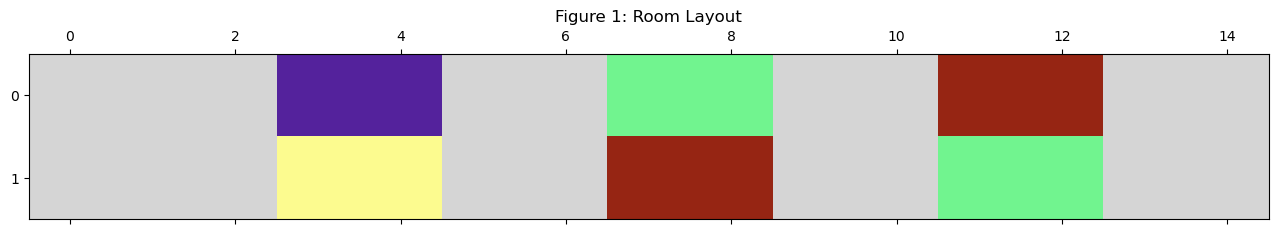

In [4]:
room = np.array([
    [0, 0, 0, 1, 1, 0, 0, 3, 3, 0, 0, 4, 4, 0, 0],
    [0, 0, 0, 2, 2, 0, 0, 4, 4, 0, 0, 3, 3, 0, 0]
])


n_emissions = room.max() + 1
print('n_emissions', n_emissions)

# Plot the layout of the room
cmap = colors.ListedColormap(custom_colors[:n_emissions])
plt.matshow(room, cmap=cmap)
plt.title('Figure 1: Room Layout')
plt.savefig("figures/rectangular_room_layout.pdf")

In [5]:
a, x, rc = datagen_structured_obs_linear_track(room, length=30)     #Use length=50000 for bigger room

print('a', a)
print('x', x)
print('rc', rc)



a [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
x [0 0 0 1 1 0 0 3 3 0 0 4 4 0 0 0 0 0 2 2 0 0 4 4 0 0 3 3 0 0]
rc [[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 13]
 [ 1 14]]


In [6]:
# Session 1

n_clones = np.ones(n_emissions, dtype=np.int64) * 25
print('n_clones', n_clones)

name = 'linear_track-session1'
file = os.path.join("models", f"{name}.pkl")
if os.path.isfile(file) and not retrain_models:
    with open(file, 'rb') as f:
        (chmm, progression) = pickle.load(f)
else:
    chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=42)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=1)  # Training   use n_iter=1000 for better training
    with open(file, 'wb') as f: # open a text file
        pickle.dump((chmm, progression), protocol=5, file=f) # Serializes model object

n_clones [25 25 25 25 25]


In [7]:
# Consolidate learning. Takes a few seconds
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)

  2%|▏         | 2/100 [00:04<03:22,  2.06s/it, train_bps=0.553]


[np.float32(5.576449), np.float32(0.55251414), np.float32(0.55251414)]

C:\Users\jacob\AppData\Local\Temp\ipykernel_34560\2987175480.py:13: RuntimeWarning: invalid value encountered in divide
  A /= A.sum(1, keepdims=True)


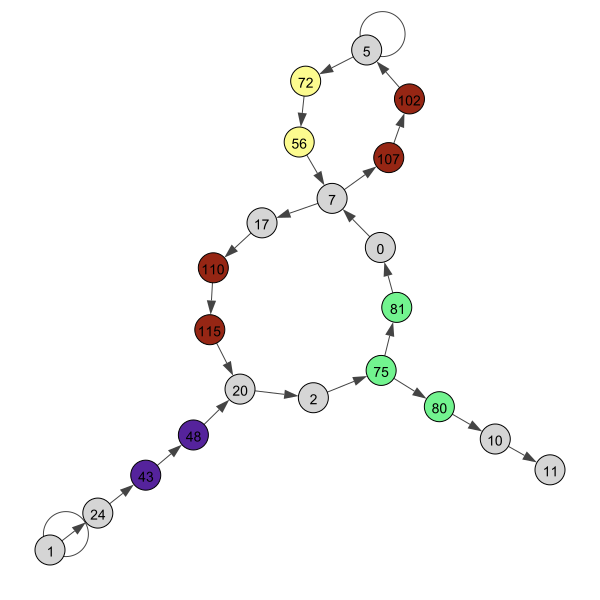

In [8]:
graph = plot_graph(
    chmm, x, a, output_file="figures/linear_track-session1.pdf", cmap=cmap
)
graph

# Look for the correspondence between the graph and the original layout of the rooom in Figure 1
# Node colors correspond to the observations from the room. Node numbers are the clone/neuron numbers.

n_clones [25 25 25 25 25]


  2%|▏         | 2/100 [00:00<00:00, 545.57it/s, train_bps=0.575]


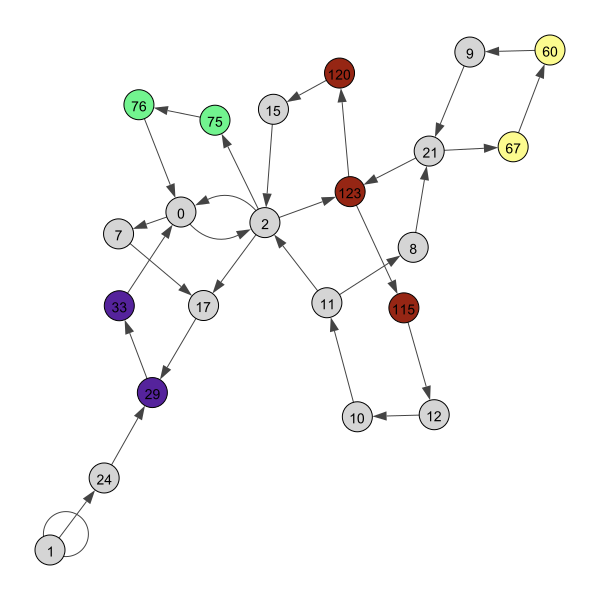

In [9]:
# Session 2
a, x, rc = datagen_structured_obs_linear_track(room, length=100)     #Use length=50000 for bigger room
print('n_clones', n_clones)

name = 'linear_track-session2'
file = os.path.join("models", f"{name}.pkl")
if os.path.isfile(file) and not retrain_models:
    with open(file, 'rb') as f:
        (chmm, progression) = pickle.load(f)
else:
    chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=42)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=5)  # Training   use n_iter=1000 for better training
    with open(file, 'wb') as f: # open a text file
        pickle.dump((chmm, progression), protocol=5, file=f) # Serializes model object

chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)
graph = plot_graph(chmm, x, a, output_file="figures/linear_track-session2.pdf", cmap=cmap)
graph

n_clones [25 25 25 25 25]


  3%|▎         | 3/100 [00:00<00:00, 106.17it/s, train_bps=0.207]


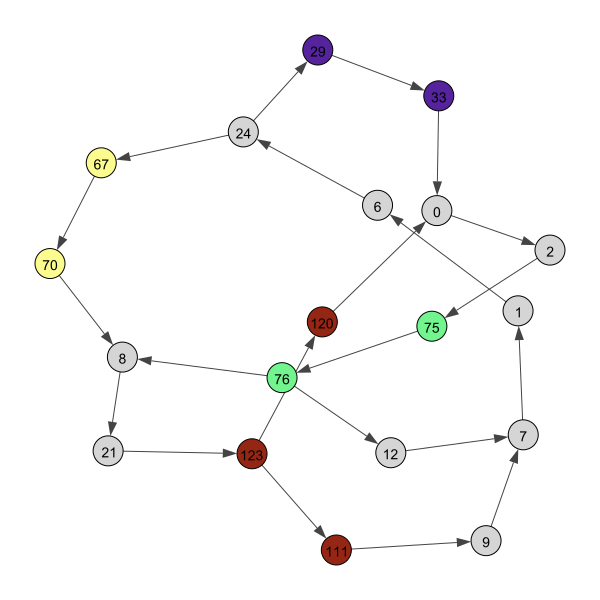

In [10]:
# Session 3
a, x, rc = datagen_structured_obs_linear_track(room, length=1000)     #Use length=50000 for bigger room
print('n_clones', n_clones)

name = 'linear_track-session3'
file = os.path.join("models", f"{name}.pkl")
if os.path.isfile(file) and not retrain_models:
    with open(file, 'rb') as f:
        (chmm, progression) = pickle.load(f)
else:
    chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=42)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=100)  # Training   use n_iter=1000 for better training
    with open(file, 'wb') as f: # open a text file
        pickle.dump((chmm, progression), protocol=5, file=f) # Serializes model object

chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)
graph = plot_graph(chmm, x, a, output_file="figures/linear_track-session3.pdf", cmap=cmap)
graph

n_clones [25 25 25 25 25]


  2%|▏         | 2/100 [00:01<00:59,  1.64it/s, train_bps=0.133]


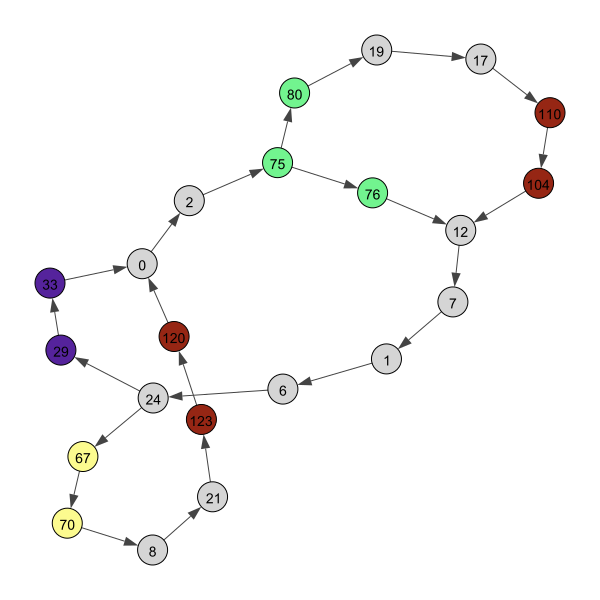

In [11]:
# Session 4
a, x, rc = datagen_structured_obs_linear_track(room, length=50000)     #Use length=50000 for bigger room
print('n_clones', n_clones)
name = 'linear_track-session4'
file = os.path.join("models", f"{name}.pkl")
if os.path.isfile(file) and not retrain_models:
    with open(file, 'rb') as f:
        (chmm, progression) = pickle.load(f)
else:
    chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=42)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training   use n_iter=1000 for better training
    with open(file, 'wb') as f: # open a text file
        pickle.dump((chmm, progression), protocol=5, file=f) # Serializes model object
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)
graph = plot_graph(chmm, x, a, output_file="figures/linear_track-session4.pdf", cmap=cmap)
graph

n_clones [75 75 75 75 75]


  2%|▏         | 2/100 [00:03<02:46,  1.70s/it, train_bps=0.0669]


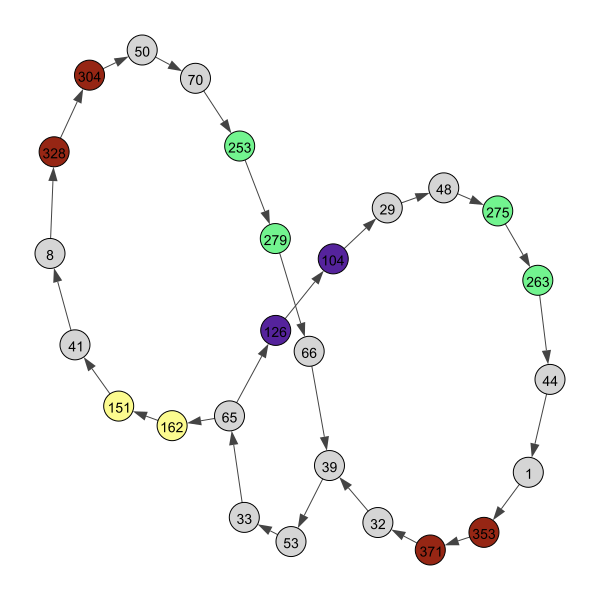

In [12]:
# Session 5
a, x, rc = datagen_structured_obs_linear_track(room, length=50000)     #Use length=50000 for bigger room
n_clones = np.ones(n_emissions, dtype=np.int64) * 75
print('n_clones', n_clones)
name = 'linear_track-session5'
file = os.path.join("models", f"{name}.pkl")
if os.path.isfile(file) and not retrain_models:
    with open(file, 'rb') as f:
        (chmm, progression) = pickle.load(f)
else:
    chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=42)  # Initialize the model
    progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training   use n_iter=1000 for better training
    with open(file, 'wb') as f: # open a text file
        pickle.dump((chmm, progression), protocol=5, file=f) # Serializes model object
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)
graph = plot_graph(chmm, x, a, output_file="figures/linear_track-session5.pdf", cmap=cmap)
graph